In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('^HSI','2020-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_18583/4010771603.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close,Prediction
Date,,,,,,
2020-01-02,28249.369141,28543.519531,28245.970703,28543.519531,28543.519531,28451.500000
2020-01-03,28828.359375,28883.300781,28428.169922,28451.500000,28451.500000,28226.189453
2020-01-06,28326.500000,28367.869141,28054.289062,28226.189453,28226.189453,28322.060547
2020-01-07,28352.679688,28473.080078,28264.070312,28322.060547,28322.060547,28087.919922
2020-01-08,27999.580078,28198.609375,27857.730469,28087.919922,28087.919922,28561.000000
...,...,...,...,...,...,...
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.539062


In [3]:
data_val=data[-100:]
data=data[:-100]

In [4]:
sc = MinMaxScaler(feature_range = (0, 1))
sc_y= MinMaxScaler(feature_range = (0, 1))

In [5]:
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(315, 1, 5) (315,) (79, 1, 5) (79,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_18583/2654051568.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [6]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-10 20:25:20.030348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 20:25:20.030465: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=700,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/700


2022-04-10 20:25:20.407512: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 20:25:21.541046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:25:21.740087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/18 [>.............................] - ETA: 26s - loss: 813848448.0000

2022-04-10 20:25:21.775802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:25:21.855112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:25:21.919310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 66ms/step - loss: 668587072.0000 - val_loss: 834471936.0000
Epoch 2/700
 6/18 [=========>....................] - ETA: 0s - loss: 658360256.0000

2022-04-10 20:25:22.974769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:25:23.046258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:25:23.070393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 10ms/step - loss: 668524416.0000 - val_loss: 834273280.0000
Epoch 3/700
18/18 [==============================] - 0s 10ms/step - loss: 668243136.0000 - val_loss: 833401152.0000
Epoch 4/700
18/18 [==============================] - 0s 10ms/step - loss: 667316224.0000 - val_loss: 831262272.0000
Epoch 5/700
18/18 [==============================] - 0s 10ms/step - loss: 665366976.0000 - val_loss: 828277568.0000
Epoch 6/700
18/18 [==============================] - 0s 10ms/step - loss: 662642304.0000 - val_loss: 825195904.0000
Epoch 7/700
18/18 [==============================] - 0s 10ms/step - loss: 659643648.0000 - val_loss: 822036224.0000
Epoch 8/700
18/18 [==============================] - 0s 10ms/step - loss: 656548608.0000 - val_loss: 818673280.0000
Epoch 9/700
18/18 [==============================] - 0s 9ms/step - loss: 653330688.0000 - val_loss: 815078720.0000
Epoch 10/700
18/18 [==============================] - 0s 10ms/step - loss: 649949760.

18/18 [==============================] - 0s 9ms/step - loss: 206523760.0000 - val_loss: 296454144.0000
Epoch 73/700
18/18 [==============================] - 0s 9ms/step - loss: 199579296.0000 - val_loss: 288047936.0000
Epoch 74/700
18/18 [==============================] - 0s 9ms/step - loss: 192752576.0000 - val_loss: 279760768.0000
Epoch 75/700
18/18 [==============================] - 0s 9ms/step - loss: 186046496.0000 - val_loss: 271595776.0000
Epoch 76/700
18/18 [==============================] - 0s 10ms/step - loss: 179463792.0000 - val_loss: 263556400.0000
Epoch 77/700
18/18 [==============================] - 0s 10ms/step - loss: 173006960.0000 - val_loss: 255645632.0000
Epoch 78/700
18/18 [==============================] - 0s 9ms/step - loss: 166678320.0000 - val_loss: 247866224.0000
Epoch 79/700
18/18 [==============================] - 0s 10ms/step - loss: 160479984.0000 - val_loss: 240220912.0000
Epoch 80/700
18/18 [==============================] - 0s 10ms/step - loss: 1544138

Epoch 143/700
18/18 [==============================] - 0s 9ms/step - loss: 5673017.5000 - val_loss: 20095388.0000
Epoch 144/700
18/18 [==============================] - 0s 9ms/step - loss: 5476080.0000 - val_loss: 19464104.0000
Epoch 145/700
18/18 [==============================] - 0s 9ms/step - loss: 5296847.5000 - val_loss: 18867186.0000
Epoch 146/700
18/18 [==============================] - 0s 10ms/step - loss: 5133985.0000 - val_loss: 18302984.0000
Epoch 147/700
18/18 [==============================] - 0s 9ms/step - loss: 4986228.0000 - val_loss: 17769808.0000
Epoch 148/700
18/18 [==============================] - 0s 10ms/step - loss: 4852383.0000 - val_loss: 17266148.0000
Epoch 149/700
18/18 [==============================] - 0s 10ms/step - loss: 4731335.0000 - val_loss: 16790508.0000
Epoch 150/700
18/18 [==============================] - 0s 9ms/step - loss: 4622039.5000 - val_loss: 16341463.0000
Epoch 151/700
18/18 [==============================] - 0s 10ms/step - loss: 4523518.5

18/18 [==============================] - 0s 10ms/step - loss: 1131805.8750 - val_loss: 4110147.5000
Epoch 215/700
18/18 [==============================] - 0s 10ms/step - loss: 1106966.0000 - val_loss: 3999056.0000
Epoch 216/700
18/18 [==============================] - 0s 10ms/step - loss: 1083001.5000 - val_loss: 3891792.0000
Epoch 217/700
18/18 [==============================] - 0s 10ms/step - loss: 1059873.0000 - val_loss: 3788186.2500
Epoch 218/700
18/18 [==============================] - 0s 10ms/step - loss: 1037538.6250 - val_loss: 3688114.0000
Epoch 219/700
18/18 [==============================] - 0s 10ms/step - loss: 1015963.8125 - val_loss: 3591399.7500
Epoch 220/700
18/18 [==============================] - 0s 10ms/step - loss: 995110.3125 - val_loss: 3497927.5000
Epoch 221/700
18/18 [==============================] - 0s 10ms/step - loss: 974947.9375 - val_loss: 3407559.5000
Epoch 222/700
18/18 [==============================] - 0s 10ms/step - loss: 955444.0000 - val_loss: 3320

Epoch 287/700
18/18 [==============================] - 0s 10ms/step - loss: 367942.6250 - val_loss: 844261.6250
Epoch 288/700
18/18 [==============================] - 0s 9ms/step - loss: 363861.7500 - val_loss: 829711.3750
Epoch 289/700
18/18 [==============================] - 0s 9ms/step - loss: 359850.7188 - val_loss: 815480.6250
Epoch 290/700
18/18 [==============================] - 0s 9ms/step - loss: 355908.0312 - val_loss: 801559.7500
Epoch 291/700
18/18 [==============================] - 0s 9ms/step - loss: 352030.8750 - val_loss: 787935.4375
Epoch 292/700
18/18 [==============================] - 0s 9ms/step - loss: 348218.9375 - val_loss: 774605.3125
Epoch 293/700
18/18 [==============================] - 0s 9ms/step - loss: 344470.0312 - val_loss: 761561.3125
Epoch 294/700
18/18 [==============================] - 0s 9ms/step - loss: 340782.1250 - val_loss: 748792.8750
Epoch 295/700
18/18 [==============================] - 0s 9ms/step - loss: 337154.8750 - val_loss: 736293.1250


18/18 [==============================] - 0s 9ms/step - loss: 183685.5000 - val_loss: 277209.1562
Epoch 361/700
18/18 [==============================] - 0s 9ms/step - loss: 182117.9844 - val_loss: 273385.5938
Epoch 362/700
18/18 [==============================] - 0s 9ms/step - loss: 180564.6875 - val_loss: 269618.3438
Epoch 363/700
18/18 [==============================] - 0s 9ms/step - loss: 179024.9688 - val_loss: 265905.1875
Epoch 364/700
18/18 [==============================] - 0s 9ms/step - loss: 177498.6875 - val_loss: 262246.4688
Epoch 365/700
18/18 [==============================] - 0s 9ms/step - loss: 175986.1250 - val_loss: 258639.4062
Epoch 366/700
18/18 [==============================] - 0s 9ms/step - loss: 174486.2969 - val_loss: 255084.7500
Epoch 367/700
18/18 [==============================] - 0s 9ms/step - loss: 172999.3438 - val_loss: 251579.2500
Epoch 368/700
18/18 [==============================] - 0s 9ms/step - loss: 171524.2812 - val_loss: 248124.4531
Epoch 369/700
1

Epoch 434/700
18/18 [==============================] - 0s 9ms/step - loss: 87775.8984 - val_loss: 88817.0469
Epoch 435/700
18/18 [==============================] - 0s 9ms/step - loss: 86540.8516 - val_loss: 87030.0703
Epoch 436/700
18/18 [==============================] - 0s 9ms/step - loss: 85302.1719 - val_loss: 85253.5781
Epoch 437/700
18/18 [==============================] - 0s 9ms/step - loss: 84060.0391 - val_loss: 83487.5312
Epoch 438/700
18/18 [==============================] - 0s 9ms/step - loss: 82813.6172 - val_loss: 81729.4062
Epoch 439/700
18/18 [==============================] - 0s 9ms/step - loss: 81563.5938 - val_loss: 79981.2266
Epoch 440/700
18/18 [==============================] - 0s 9ms/step - loss: 80308.7578 - val_loss: 78241.7344
Epoch 441/700
18/18 [==============================] - 0s 9ms/step - loss: 79049.2266 - val_loss: 76511.1562
Epoch 442/700
18/18 [==============================] - 0s 10ms/step - loss: 77784.7109 - val_loss: 74788.1719
Epoch 443/700
18/1

18/18 [==============================] - 0s 9ms/step - loss: 26597.4375 - val_loss: 11404.0928
Epoch 510/700
18/18 [==============================] - 0s 9ms/step - loss: 28126.0293 - val_loss: 11662.3066
Epoch 511/700
18/18 [==============================] - 0s 9ms/step - loss: 30037.5020 - val_loss: 12044.5518
Epoch 512/700
18/18 [==============================] - 0s 9ms/step - loss: 32408.6328 - val_loss: 12576.5137
Epoch 513/700
18/18 [==============================] - 0s 9ms/step - loss: 35325.1836 - val_loss: 13286.7314
Epoch 514/700
18/18 [==============================] - 0s 9ms/step - loss: 38879.4609 - val_loss: 14205.3516
Epoch 515/700
18/18 [==============================] - 0s 9ms/step - loss: 43165.2148 - val_loss: 15361.8672
Epoch 516/700
18/18 [==============================] - 0s 9ms/step - loss: 48269.5117 - val_loss: 16779.0664
Epoch 517/700
18/18 [==============================] - 0s 9ms/step - loss: 54254.9688 - val_loss: 18459.8398
Epoch 518/700
18/18 [============

18/18 [==============================] - 0s 10ms/step - loss: 21689.7891 - val_loss: 8706.9512
Epoch 585/700
18/18 [==============================] - 0s 10ms/step - loss: 24716.5312 - val_loss: 9341.6309
Epoch 586/700
18/18 [==============================] - 0s 9ms/step - loss: 28634.6875 - val_loss: 10256.8213
Epoch 587/700
18/18 [==============================] - 0s 10ms/step - loss: 33633.1523 - val_loss: 11533.5322
Epoch 588/700
18/18 [==============================] - 0s 10ms/step - loss: 39941.6094 - val_loss: 13289.2178
Epoch 589/700
18/18 [==============================] - 0s 10ms/step - loss: 47848.1406 - val_loss: 15696.2734
Epoch 590/700
18/18 [==============================] - 0s 9ms/step - loss: 57716.2188 - val_loss: 18991.7148
Epoch 591/700
18/18 [==============================] - 0s 9ms/step - loss: 70000.0703 - val_loss: 23469.6445
Epoch 592/700
18/18 [==============================] - 0s 9ms/step - loss: 85220.4453 - val_loss: 29403.5391
Epoch 593/700
18/18 [=========

Epoch 659/700
18/18 [==============================] - 0s 9ms/step - loss: 12414.8076 - val_loss: 6548.1357
Epoch 660/700
18/18 [==============================] - 0s 10ms/step - loss: 13301.1572 - val_loss: 6458.7793
Epoch 661/700
18/18 [==============================] - 0s 9ms/step - loss: 14597.2383 - val_loss: 6502.3047
Epoch 662/700
18/18 [==============================] - 0s 9ms/step - loss: 16404.7207 - val_loss: 6703.9141
Epoch 663/700
18/18 [==============================] - 0s 9ms/step - loss: 18841.8184 - val_loss: 7093.4673
Epoch 664/700
18/18 [==============================] - 0s 9ms/step - loss: 22044.5938 - val_loss: 7711.2090
Epoch 665/700
18/18 [==============================] - 0s 10ms/step - loss: 26171.8262 - val_loss: 8613.2900
Epoch 666/700
18/18 [==============================] - 0s 11ms/step - loss: 31411.3047 - val_loss: 9885.8271
Epoch 667/700
18/18 [==============================] - 0s 10ms/step - loss: 37995.6406 - val_loss: 11660.3359
Epoch 668/700
18/18 [==

2022-04-10 20:27:27.757625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:27:27.840907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:27:27.877285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


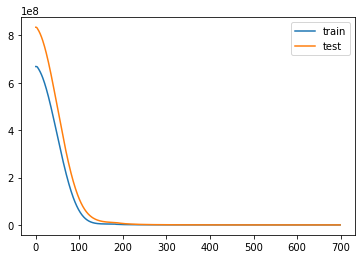

In [8]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

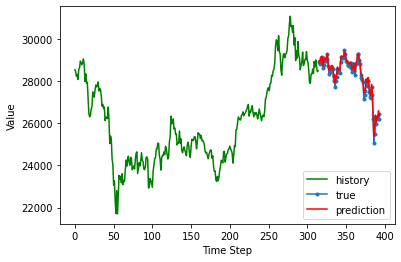

In [9]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

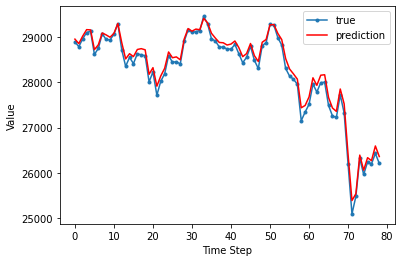

In [10]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [11]:
r2_score(y_test,y_pred)

0.9839870118789746

In [12]:
mean_absolute_percentage_error(y_test,y_pred)

0.0038647956593590277

In [13]:
mean_squared_error(y_test,y_pred,squared=False)

122.83460585431207

In [14]:
x_val=data_val.drop('Prediction',1).values
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_18583/264374676.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


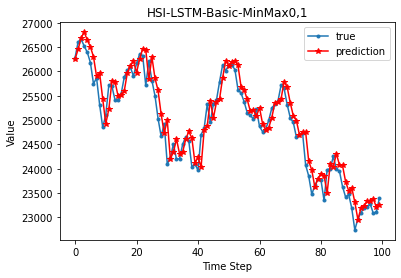

In [19]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-Basic-MinMax0,1')
plt.legend()
plt.show()

In [16]:
r2_score(y_val,y_val_pred)

0.9017070580503154

In [17]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.009864696691090457

In [18]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

314.9424137832721